train   : 非骨质疏松=751, 骨质疏松=396
test    : 非骨质疏松=95, 骨质疏松=48
val     : 非骨质疏松=95, 骨质疏松=50
extest  : 非骨质疏松=65, 骨质疏松=38

Epoch 1/5


train  : acc=0.6754  auc=0.6569 [0.6237-0.6904]  precision=0.5734  recall=0.2097  specificity=0.9186  f1=0.3071


test   : acc=0.6573  auc=0.5717 [0.4672-0.6756]  precision=0.4737  recall=0.1875  specificity=0.8947  f1=0.2687


val    : acc=0.7014  auc=0.6290 [0.5306-0.7304]  precision=0.6667  recall=0.2449  specificity=0.9368  f1=0.3582


extest : acc=0.7087  auc=0.7623 [0.6639-0.8559]  precision=0.6333  recall=0.5000  specificity=0.8308  f1=0.5588


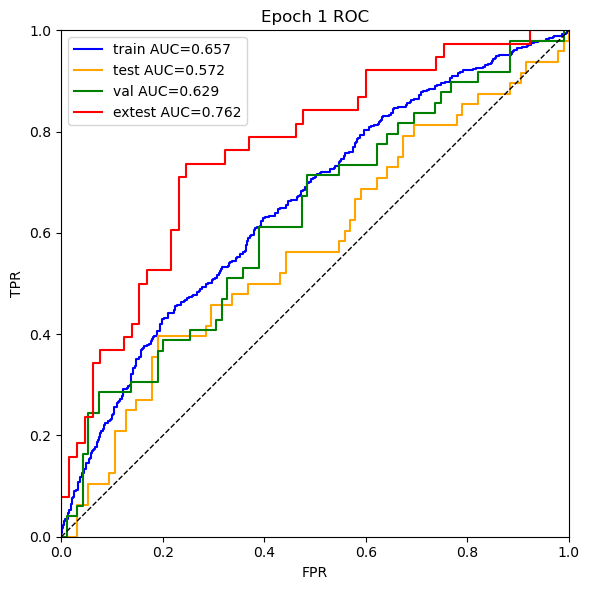


Epoch 2/5


train  : acc=0.6754  auc=0.6643 [0.6315-0.6980]  precision=0.6842  recall=0.0997  specificity=0.9760  f1=0.1741


test   : acc=0.6364  auc=0.5904 [0.4873-0.6901]  precision=0.3000  recall=0.0625  specificity=0.9263  f1=0.1034


val    : acc=0.6528  auc=0.6498 [0.5506-0.7450]  precision=0.4286  recall=0.0612  specificity=0.9579  f1=0.1071


extest : acc=0.6893  auc=0.7397 [0.6315-0.8340]  precision=0.8750  recall=0.1842  specificity=0.9846  f1=0.3043


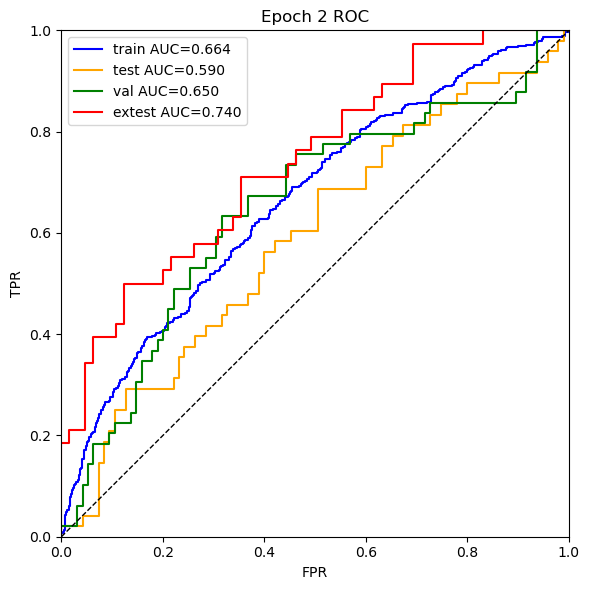


Epoch 3/5


train  : acc=0.6789  auc=0.6706 [0.6382-0.7039]  precision=0.6087  recall=0.1790  specificity=0.9399  f1=0.2767


test   : acc=0.6573  auc=0.5761 [0.4735-0.6769]  precision=0.4545  recall=0.1042  specificity=0.9368  f1=0.1695


val    : acc=0.6597  auc=0.5953 [0.4990-0.6899]  precision=0.5000  recall=0.1429  specificity=0.9263  f1=0.2222


extest : acc=0.7476  auc=0.6709 [0.5409-0.7832]  precision=0.8000  recall=0.4211  specificity=0.9385  f1=0.5517


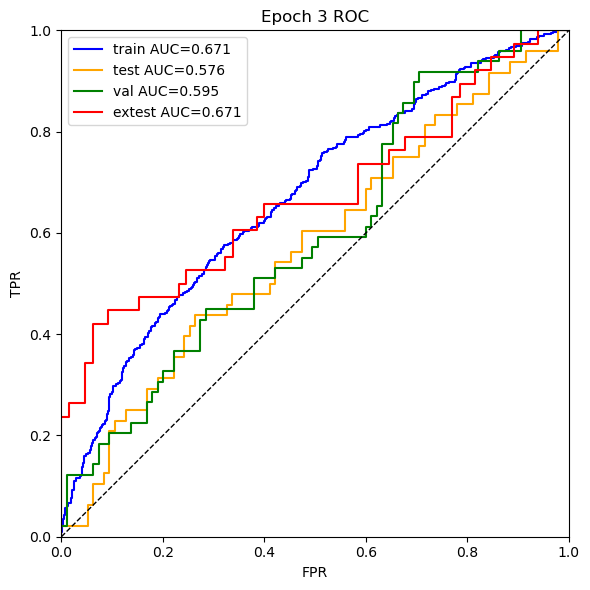


Epoch 4/5


train  : acc=0.7000  auc=0.7312 [0.6999-0.7612]  precision=0.7379  recall=0.1944  specificity=0.9640  f1=0.3077


test   : acc=0.6573  auc=0.6419 [0.5349-0.7365]  precision=0.4444  recall=0.0833  specificity=0.9474  f1=0.1404


val    : acc=0.7083  auc=0.6110 [0.5115-0.7071]  precision=0.8889  recall=0.1633  specificity=0.9895  f1=0.2759


extest : acc=0.7282  auc=0.7198 [0.6022-0.8177]  precision=0.8125  recall=0.3421  specificity=0.9538  f1=0.4815


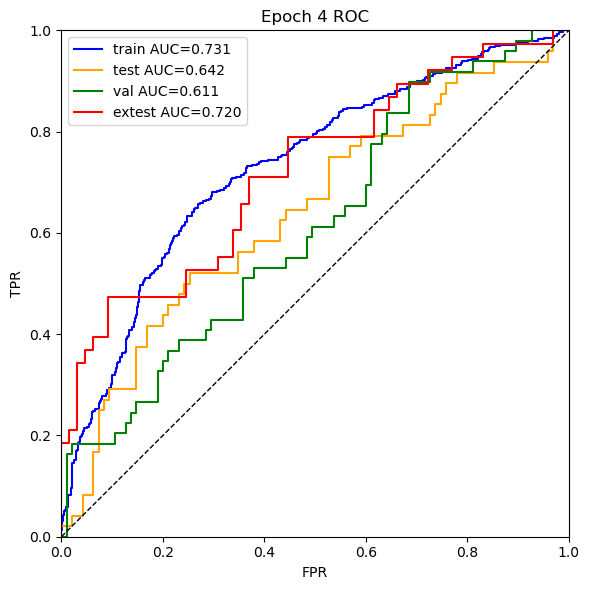


Epoch 5/5


train  : acc=0.7079  auc=0.7441 [0.7140-0.7736]  precision=0.6526  recall=0.3171  specificity=0.9119  f1=0.4269


test   : acc=0.6923  auc=0.6412 [0.5352-0.7361]  precision=0.5909  recall=0.2708  specificity=0.9053  f1=0.3714


val    : acc=0.6736  auc=0.6189 [0.5178-0.7125]  precision=0.5556  recall=0.2041  specificity=0.9158  f1=0.2985


extest : acc=0.7184  auc=0.7283 [0.6126-0.8263]  precision=0.7143  recall=0.3947  specificity=0.9077  f1=0.5085


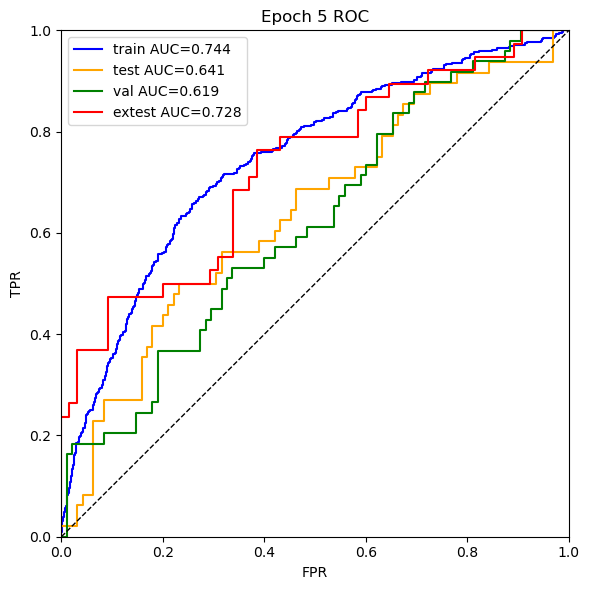


========== 最终平均指标（合并所有样本 + Bootstrap 95% CI） ==========


train  : acc=0.6754  auc=0.6569 [0.6244-0.6891]  precision=0.5734  recall=0.2097  specificity=0.9186  f1=0.3071


test   : acc=0.6573  auc=0.5717 [0.4672-0.6756]  precision=0.4737  recall=0.1875  specificity=0.8947  f1=0.2687


val    : acc=0.7014  auc=0.6290 [0.5306-0.7304]  precision=0.6667  recall=0.2449  specificity=0.9368  f1=0.3582


extest : acc=0.7087  auc=0.7623 [0.6639-0.8559]  precision=0.6333  recall=0.5000  specificity=0.8308  f1=0.5588


In [1]:
# run.py
import os, warnings, copy, math, random, time
import numpy as np
import pandas as pd
import nibabel as nib
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from sklearn.metrics import (roc_auc_score, roc_curve, accuracy_score,
                             precision_score, recall_score, f1_score,
                             confusion_matrix)
from skimage.transform import resize   # pip install scikit-image
warnings.filterwarnings('ignore')

# ------------------ Bootstrap AUC 95% CI ------------------
def bootstrap_auc_ci(y_true, y_score, n_boot=2000, ci=0.95, rng_seed=42):
    rng = np.random.default_rng(rng_seed)
    aucs = []
    n = len(y_true)
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        try:
            aucs.append(roc_auc_score(y_true[idx], y_score[idx]))
        except ValueError:
            continue
    aucs = np.array(aucs)
    auc = roc_auc_score(y_true, y_score)
    lower, upper = np.percentile(aucs, [(1-ci)/2*100, (1+ci)/2*100])
    return auc, lower, upper

# ========== 全局 ==========
DEVICE   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ROOT_DIR = r'D:/骨密度数据集'
TABLES   = ['train_table.xlsx', 'test_table.xlsx', 'val_table.xlsx', 'extest_table.xlsx']
PHASES   = ['train', 'test', 'val', 'extest']
NII_NAMES= ['zw.nii', 'cw.nii']
SEED     = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# 1. 读取 Excel & 统计
stats = {}
dfs   = {}
for tbl, phase in zip(TABLES, PHASES):
    df = pd.read_excel(os.path.join(ROOT_DIR, tbl))
    df['phase'] = phase
    dfs[phase] = df
    pos = df['是否骨质疏松'].sum()
    neg = len(df) - pos
    stats[phase] = (neg, pos)
    print(f'{phase:<8}: 非骨质疏松={neg}, 骨质疏松={pos}')

# 2. Dataset
class BMDDataset(Dataset):
    def __init__(self, df, max_slices=16, target_shape=(224, 224)):
        self.records = df.to_dict('records')
        self.max_slices, self.target_shape = max_slices, target_shape

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        rec  = self.records[idx]
        pid  = str(rec['ID'])
        phase= rec['phase']
        vols = []
        for mod in NII_NAMES:
            path = os.path.join(ROOT_DIR, phase, pid, mod)
            if not os.path.isfile(path):
                return None
            try:
                vol = nib.load(path).get_fdata().astype(np.float32)
            except Exception:
                return None
            vol = resize(vol, self.target_shape + (vol.shape[2],),
                         mode='constant', preserve_range=True)
            vol = (vol - vol.min()) / (vol.max() - vol.min() + 1e-8)
            vols.append(vol)
        D = vols[0].shape[2]
        for v in vols:
            if v.shape[2] != D:
                return None
        if D > self.max_slices:
            start = (D - self.max_slices)//2
            vols  = [v[..., start:start+self.max_slices] for v in vols]
        else:
            pad   = self.max_slices - D
            vols  = [np.pad(v, ((0,0),(0,0),(0,pad)), mode='constant') for v in vols]
        img = np.concatenate(vols, axis=0)
        img = torch.from_numpy(img).float()
        label = int(rec['是否骨质疏松'])
        return img, label, pid

def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None, None, None
    return torch.utils.data.dataloader.default_collate(batch)

BATCH = 4
loaders = {p: DataLoader(BMDDataset(dfs[p]), batch_size=BATCH,
                         shuffle=(p=='train'), num_workers=0,
                         collate_fn=collate_fn) for p in PHASES}

# 3. 模型
class ResNet3DWrapper(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.backbone = base_model
        self.backbone.fc = nn.Identity()
        self.classifier = nn.Linear(512, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b*c, 1, h, w).repeat(1, 3, 1, 1)
        feats = self.backbone(x)
        feats = feats.view(b, c, -1).mean(dim=1)
        return self.classifier(feats).squeeze(1)

model = ResNet3DWrapper(resnet18(weights='IMAGENET1K_V1')).to(DEVICE)

# 4. 训练配置
LR, EPOCHS = 1e-4, 5
criterion  = nn.BCEWithLogitsLoss()
optimizer  = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler  = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

def metrics(y_true, y_score):
    y_pred = (y_score > 0.5).astype(int)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    spec = tn/(tn+fp+1e-8)
    try:
        auc = roc_auc_score(y_true, y_score)
    except:
        auc = np.nan
    return dict(acc=acc, auc=auc, precision=prec,
                specificity=spec, recall=rec, f1=f1)

@torch.no_grad()
def evaluate(phase, collect=False):
    model.eval()
    all_labels, all_scores = [], []
    for imgs, labels, _ in tqdm(loaders[phase], desc=phase, leave=False):
        if imgs is None:
            continue
        imgs, labels = imgs.to(DEVICE), labels.float().to(DEVICE)
        logits = model(imgs)
        scores = torch.sigmoid(logits).cpu().numpy()
        all_scores.append(scores)
        all_labels.append(labels.cpu().numpy())
    if len(all_labels) == 0:
        return None, None, None
    # 强制转 int
    y_true  = np.concatenate(all_labels).astype(int)
    y_score = np.concatenate(all_scores)
    m = metrics(y_true, y_score)
    m['auc'], m['auc_lower'], m['auc_upper'] = bootstrap_auc_ci(y_true, y_score)
    if collect:
        m['y_true']  = y_true
        m['y_score'] = y_score
    return m, y_true, y_score

# 5. 训练循环（每 epoch 复用同一图）
# 5. 训练循环（每 epoch 画 4 条 ROC，4 条曲线画在同一张图上）
history = {p: [] for p in PHASES}
best_auc = 0.
colors = ['blue', 'orange', 'green', 'red']   # train/test/val/extest 顺序

for epoch in range(1, EPOCHS + 1):
    print(f'\nEpoch {epoch}/{EPOCHS}')
    # ---------- train ----------
    model.train()
    running_loss = 0.
    for imgs, labels, _ in tqdm(loaders['train'], desc='train', leave=False):
        if imgs is None:
            continue
        imgs, labels = imgs.to(DEVICE), labels.float().to(DEVICE)
        logits = model(imgs)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    scheduler.step()

    # ---------- 评估 4 个集合 ----------
    fig, ax = plt.subplots(figsize=(6, 6))
    for phase, color in zip(PHASES, colors):
        m, y_true, y_score = evaluate(phase)
        if m is None:
            continue
        history[phase].append(m)
        print(f'{phase:<7}: '
              f'acc={m["acc"]:.4f}  '
              f'auc={m["auc"]:.4f} [{m["auc_lower"]:.4f}-{m["auc_upper"]:.4f}]  '
              f'precision={m["precision"]:.4f}  '
              f'recall={m["recall"]:.4f}  '
              f'specificity={m["specificity"]:.4f}  '
              f'f1={m["f1"]:.4f}')
        fpr, tpr, _ = roc_curve(y_true, y_score)
        ax.plot(fpr, tpr, color=color, label=f'{phase} AUC={m["auc"]:.3f}')
    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_title(f'Epoch {epoch} ROC')
    ax.legend()
    plt.tight_layout()
    plt.show(block=False)          # 非阻塞显示，Jupyter 用户可改为 plt.show()
    plt.pause(1)                   # 让 GUI 有时间刷新
    plt.close(fig)                 # 关闭当前 epoch 图（不想关可注释）

    # ---------- 保存 best ----------
    val_ext = [h['auc'] for h in history['val'] + history['extest'] if h]
    if val_ext and np.nanmean(val_ext) > best_auc:
        best_auc = np.nanmean(val_ext)
        torch.save(model.state_dict(), 'best.pth')

# 6. 最终平均指标 & ROC（合并样本 + Bootstrap 95% CI）
print('\n========== 最终平均指标（合并所有样本 + Bootstrap 95% CI） ==========')
ax.clear()
model.load_state_dict(torch.load('best.pth', map_location=DEVICE))

for phase, color in zip(PHASES, colors):
    m, y_true, y_score = evaluate(phase, collect=True)
    if m is None:
        continue
    ci_auc, ci_low, ci_up = m['auc'], m['auc_lower'], m['auc_upper']
    print(f'{phase:<7}: '
          f'acc={m["acc"]:.4f}  '
          f'auc={ci_auc:.4f} [{ci_low:.4f}-{ci_up:.4f}]  '
          f'precision={m["precision"]:.4f}  '
          f'recall={m["recall"]:.4f}  '
          f'specificity={m["specificity"]:.4f}  '
          f'f1={m["f1"]:.4f}')
    fpr, tpr, _ = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr, color=color,
            label=f'{phase} AUC={ci_auc:.3f} [{ci_low:.3f}-{ci_up:.3f}]')

ax.plot([0,1],[0,1],'k--'); ax.set_xlim(0,1); ax.set_ylim(0,1)
ax.set_xlabel('FPR'); ax.set_ylabel('TPR')
ax.legend(); ax.set_title('Final ROC with Bootstrap 95% CI'); plt.show()


In [2]:
# ====================== 保存每个患者的完整预测结果 ======================
print("\n========== 保存每个患者的完整预测结果 ==========")

import csv

threshold = 0.5   # 如需调整阈值，改这里

for split in PHASES:               # PHASES = ['train','test','val','extest']
    loader = loaders[split]
    if len(loader.dataset) == 0:
        continue

    model.eval()
    results = []

    with torch.no_grad():
        for imgs, labels, pids in tqdm(loader, desc=f'{split} saving', leave=False):
            if imgs is None:
                continue
            imgs = imgs.to(DEVICE)
            logits = model(imgs)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs >= threshold).astype(int)

            for pid, true_l, p, pred_l in zip(pids, labels.cpu().numpy(), probs, preds):
                results.append([pid, int(true_l), f"{p:.6f}", int(pred_l)])

    csv_path = f"{split}_results.csv"
    with open(csv_path, 'w', newline='', encoding='utf-8-sig') as f:
        writer = csv.writer(f)
        writer.writerow(['ID', 'true_label', 'pred_prob', 'pred_label'])
        writer.writerows(results)

    print(f"{split.upper()} 已保存：{csv_path}，共 {len(results)} 条记录")


========== 保存每个患者的完整预测结果 ==========


TRAIN 已保存：train_results.csv，共 1140 条记录


TEST 已保存：test_results.csv，共 143 条记录


VAL 已保存：val_results.csv，共 144 条记录


EXTEST 已保存：extest_results.csv，共 103 条记录
